<a href="https://colab.research.google.com/github/cemrecirak/DSA210-Project/blob/main/Data%20Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from os.path import join

def kategori_belirle(urun_adi):
    name = str(urun_adi).lower()


    if "kurutma" in name:
        return "Dryer"
    elif "çamaşır" in name or "wga25" in name:
        return "Washing Machine"
    elif "kıyma" in name:
        return "Meat Grinder"
    elif "bulaşık" in name or "sms4" in name:
        return "Dishwasher"
    elif "fırın" in name:
        return "Oven"
    elif "solo soğ." in name or "buzdolabı" in name or "kgn86" in name:
        return "Refrigerator"
    elif "süpürge" in name or "bbs6" in name:
        return "Vacuum Cleaner"
    elif "kahve" in name:
        return "Coffee Machine"
    elif "mikser" in name or "mfq3010" in name:
        return "Mixer"
    elif "mmr08r2" in name or "blender" in name or "ms6cb" in name:
        return "Blender"
    elif "robot" in name or "mutfak" in name:
        return "Kitchen Robot"
    elif "ocak" in name:
        return "Cooktop"
    elif "davlumbaz" in name or "aspiratör" in name:
        return "Extractor Hood"
    elif "cam su" in name or "çay makinesi" in name or "kettle" in name:
        return "Kettle/Tea Maker"
    elif "derin" in name:
        return "Deep Freezer"
    elif "tost" in name:
        return "Toaster"
    elif "ekmek" in name:
        return "Toaster (Bread)"
    elif "toz tor" in name:
        return "Dust Bag"
    else:
        return "Other"

drive.mount('/content/drive', force_remount=True)

satisraporu = "/content/drive/MyDrive/dsaproje/agustossatis.csv"

df = pd.read_csv(satisraporu, delimiter=";")

df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

#Eliminate irrelevant data
irrelevant_columns = ['barkod', 'kargoya_teslim_tarihi','komisyon_oranı', 'teslim_tarihi', 'ülke', 'sipariş_statüsü', 'stok_kodu', 'paket_no', 'kargo_firması', 'termin_süresinin_bittiği_tarih','alıcı_-_fatura_adresi','vergi_dairesi','e-posta', 'fatura_adresi', 'şirket_i̇smi','alternatif_teslimat_statüsü','faturalanan_kargo_tutarı', 'marka','butik_numarası','i̇ndirim_tutarı',	'trendyol_i̇ndirim_tutarı','faturalanacak_tutar','teslimat_adresi','kargodan_alınan_desi','hesapladığım_desi','kurumsal_faturalı_sipariş','fatura','müşteri_sipariş_adedi', 'vergi_kimlik_numarası','mikro_i̇hracat','etgb_no', 'etgb_tarihi', 'kargo_kodu','sipariş_numarası','kargo_partner_i̇smi', '2.teslimat_paketi_statüsü','2.teslimat_takip_numarası','teslimat_numarası','fatura_no','fatura_tarihi','müşteri_telefon_no']

df.drop(columns=[col for col in irrelevant_columns if col in df.columns], inplace=True)

#Extract the category names
df['category'] = df['product_name'].apply(kategori_belirle)

df['order_date'] = pd.to_datetime(df['order_date'], format="%d.%m.%Y %H:%M", errors='coerce')


df['hour'] = df['order_date'].dt.hour
df['day_of_week'] = df['order_date'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

df.head()

# STEP 1: Load name frequency files (Yüklediğin dosya adları doğruysa)
female_raw = pd.read_csv("/content/drive/MyDrive/dsaproje/female_name_tally", header=None, names=["raw"])
male_raw = pd.read_csv("/content/drive/MyDrive/dsaproje/male_name_tally", header=None, names=["raw"])
unisex_raw = pd.read_csv("/content/drive/MyDrive/dsaproje/unisex_name_tally_filtered", header=None, names=["raw"])

# STEP 2: Temizleme fonksiyonu
def process_name_freq(df):
  df[['name', 'frequency']] = df['raw'].str.extract(r'(\D+)\s+(\d+)', expand=True)
  df = df.dropna(subset=['name', 'frequency']).copy()
  df['name'] = df['name'].str.strip().str.lower()
  df['frequency'] = df['frequency'].astype(int)

  return df.drop(columns=['raw'])

# STEP 3: Apply to all
female_df = process_name_freq(female_raw)
male_df = process_name_freq(male_raw)
unisex_df = process_name_freq(unisex_raw)

def normalize_turkish(name):
    replacements = {
        'Ç': 'c', 'ç': 'c',
        'Ğ': 'g', 'ğ': 'g',
        'I': 'i', 'ı': 'i',
        'İ': 'i',
        'Ö': 'o', 'ö': 'o',
        'Ş': 's', 'ş': 's',
        'Ü': 'u', 'ü': 'u'
    }
    name = str(name).strip()
    for turkish, ascii in replacements.items():
        name = name.replace(turkish, ascii)
    name = name.lower()
    return name

df['normalized_name'] = df['customer'].apply(normalize_turkish)

# STEP 4: Cinsiyet tahmin fonksiyonu
def infer_gender_from_name(name):
    name = normalize_turkish(str(name).split()[0])
    male_freq = male_df[male_df['name'] == name]['frequency'].sum()
    female_freq = female_df[female_df['name'] == name]['frequency'].sum()

    if male_freq > 0 and female_freq > 0:
        return "Male" if male_freq > female_freq else "Female"
    elif male_freq > 0:
        return "Male"
    elif female_freq > 0:
        return "Female"
    else:
        return "Unknown"


# STEP 5: Apply to your data (eğer isim sütunun adı 'alıcı' ise)
df['guessed_gender'] = df['normalized_name'].apply(infer_gender_from_name)

df.head()

Mounted at /content/drive


,order_date,customer,city,district,product_name,quantity,unit_price,total_revenue,age,gender,category,hour,day_of_week,is_weekend,normalized_name,guessed_gender
0,2024-08-04 01:52:00,Uğur Koca,İstanbul,Pendik,"Hbf514bw1t Beyaz Ankastre Fırın HBF514BW1T, on...",1,10535.0,10535.0,NaN,Male,Oven,1,Sunday,True,ugur koca,Male
1,2024-08-04 03:40:00,Tuğçe Esra Özbey,Bursa,Nilüfer,GSV33VIE0N Inox 7 Çekmeceli Derin Dondurucu GS...,1,16571.0,16571.0,NaN,Not Specified,Deep Freezer,3,Sunday,True,tugce esra ozbey,Female
2,2024-08-04 03:52:00,fethi doğan,Elazığ,Merkez,Wga142x2tr 9 Kg 1200 Devir A Enerji Sınıfı Bey...,1,16170.0,16170.0,NaN,Male,Washing Machine,3,Sunday,True,fethi dogan,Male
3,2024-08-04 03:52:00,fethi doğan,Elazığ,Merkez,"Hbf514bw1t Beyaz Ankastre Fırın HBF514BW1T, on...",1,10535.0,10535.0,NaN,Male,Oven,3,Sunday,True,fethi dogan,Male
4,2024-08-04 05:06:00,Sadegül ÖNAL,Kastamonu,Merkez,Sms4ıkw62t 6 Programlı Beyaz Bulaşık Makinesi ...,1,16095.0,16095.0,21-30,Female,Dishwasher,5,Sunday,True,sadegul onal,Female


In [28]:
unknown_names = df[df['guessed_gender'] == 'Unknown'][['customer', 'normalized_name']]
print(unknown_names.drop_duplicates())


             customer   normalized_name
25   Muhamnet Beyatli  muhamnet beyatli
139    TY Demir Cargo    ty demir cargo
161    javıd eısapour    javid eisapour


In [ ]:
# Age grouping and handling missing values
bins = [0, 25, 35, 45, 60, 120]
labels = ['18–25', '26–35', '36–45', '46–60', '60+']

# Convert 'age' column to numeric, handling errors
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Create age group
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Add "Unknown" as a category and fill NaNs
df['age_group'] = df['age_group'].cat.add_categories("Unknown").fillna("Unknown")

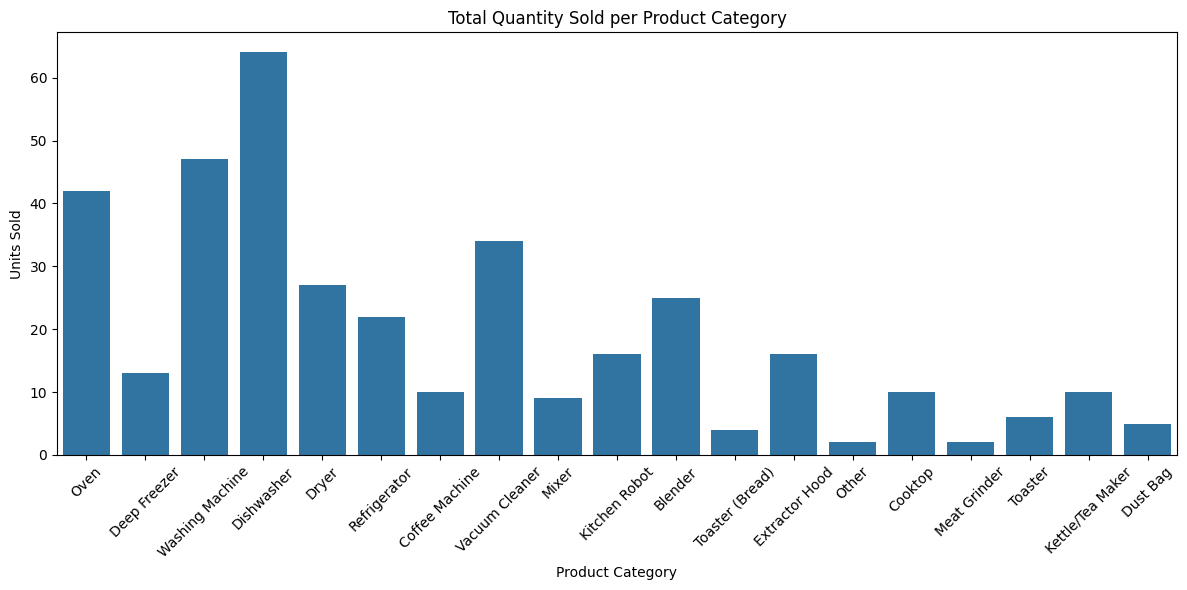

In [98]:
# 2. Total Quantity Sold by Category
plt.figure(figsize=(12,6))
sns.barplot(x='category', y='quantity', data=df, estimator=sum, errorbar=None)
plt.xticks(rotation=45)
plt.title("Total Quantity Sold per Product Category")
plt.ylabel("Units Sold")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()


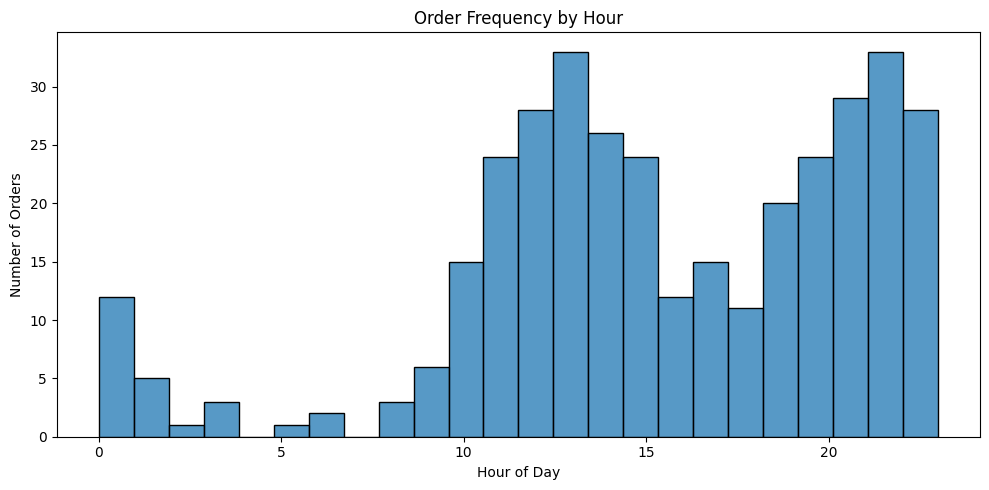

In [ ]:
# 3. Order Count by Hour of Day
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='hour', bins=24, kde=False, stat="count")
plt.title("Order Frequency by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


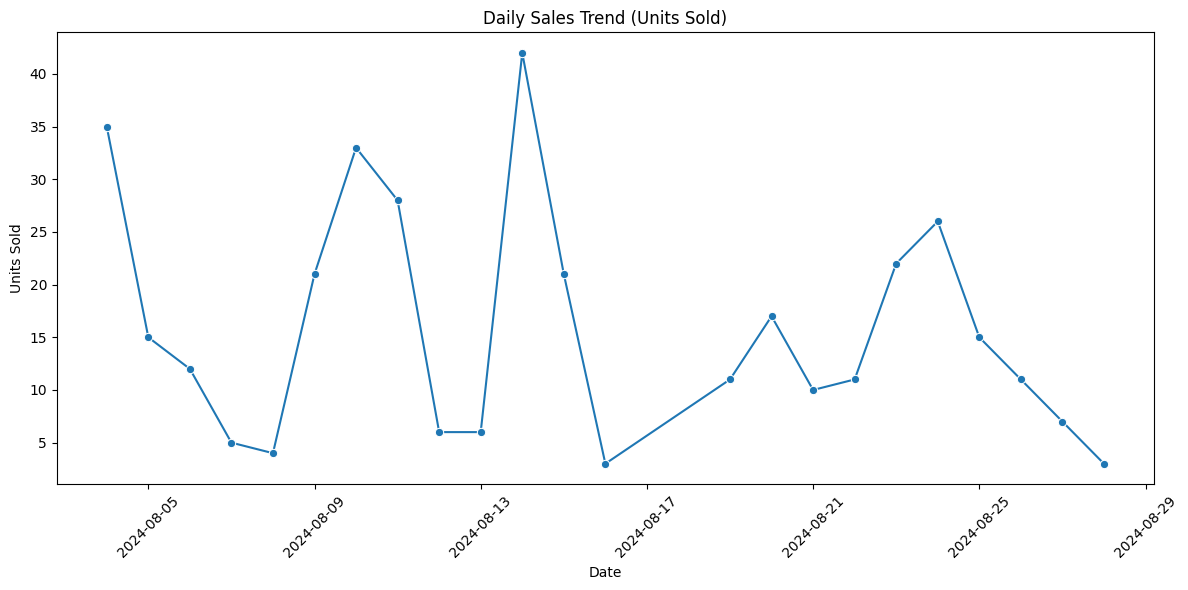

In [ ]:
# 4. Daily Sales Trend (Time Series)
df['order_date_only'] = df['order_date'].dt.date
daily_sales = df.groupby('order_date_only')['quantity'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sales, x='order_date_only', y='quantity', marker='o')
plt.title("Daily Sales Trend (Units Sold)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


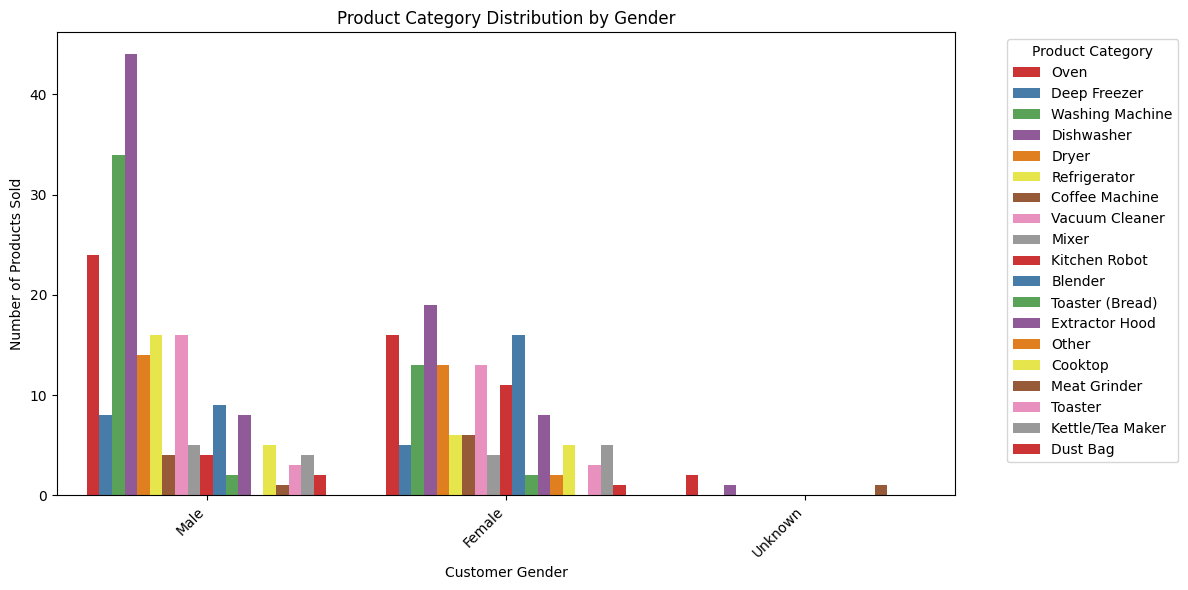

In [30]:
# Visualizing Product Category by Customer Gender
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.countplot(x='guessed_gender', hue='category', data=df, palette="Set1", dodge=True)  # Changes here
plt.title("Product Category Distribution by Gender")
plt.ylabel("Number of Products Sold")
plt.xlabel("Customer Gender")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import chi2_contingency
import pandas as pd

# Drop missing gender/category values
df_chi = df[['guessed_gender', 'category']].dropna()

# Create contingency table
contingency = pd.crosstab(df_chi['guessed_gender'], df_chi['category'])

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square value:", round(chi2, 4))
print("p-value:", round(p, 4))
print("Degrees of freedom:", dof)

if p < 0.05:
    print("Reject H₀ → Gender and category are associated.")
else:
    print("Fail to reject H₀ → No significant association between gender and category.")


Chi-square value: 52.1014
p-value: 0.0403
Degrees of freedom: 36
Reject H₀ → Gender and category are associated.


In [ ]:
from scipy.stats import ttest_ind

# Group data
weekend_sales = df[df['is_weekend'] == True]['quantity']
weekday_sales = df[df['is_weekend'] == False]['quantity']

# t-test
stat, p = ttest_ind(weekend_sales, weekday_sales, equal_var=False)

print("t-statistic:", round(stat, 4))
print("p-value:", round(p, 4))

if p < 0.05:
    print("Reject H₀ → Sales differ between weekdays and weekends.")
else:
    print("Fail to reject H₀ → No significant difference in sales.")


t-statistic: 1.0546
p-value: 0.2928
Fail to reject H₀ → No significant difference in sales.


In [13]:
from scipy.stats import f_oneway

# Group by hour
hourly_groups = [group['quantity'].values for _, group in df.groupby('hour') if len(group) > 1]

# Run ANOVA
f_stat, p = f_oneway(*hourly_groups)

print("F-statistic:", round(f_stat, 4))
print("p-value:", round(p, 4))

if p < 0.05:
    print("Reject H₀ → Sales quantities differ significantly by hour.")
else:
    print("Fail to reject H₀ → No significant difference by hour.")


F-statistic: 0.8624
p-value: 0.6304
Fail to reject H₀ → No significant difference by hour.
